# Week 1 Project: Building a Leaf Classification App

Welcome to the first week's project for *Building Computer Vision Applications*!

In this week, we are going to get familiar with the key steps of building machine learning apps, with a particular focus on image classification. Specifically, we will cover:

* finding computer vision datasets and pretrained models 📖
* fine-tuning an image classifier model on new data 👾
* deploying a [Gradio app](http://gradio.dev/) you can run on your phone or laptop 📷
* measuring the performance of a classification model on test data and the real world 📈

# Introduction

Beans are an important cereal food crop in many parts of the world. However, certain diseases can damage bean plants, causing food shortages. As a result, it is critical to monitor the leaves of bean plants frequently and accurately. Many farming businesses are turning to imaging and machine learning to monitor their crops automatically and accurately.

This is a great example of where **image classification** can solve a real business problem. The concepts you will learn in this project will be generally applicable to many other kinds of image classification, and more broadly machine learning, tasks. 

Our end goal will be to build a web-application that can take in an image of a bean leaf and predict whether it is healthy or diseased. The app will look something like this: 

![](https://i.ibb.co/6mcXB53/image.png)

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our Colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your Colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to load our dataset (`datasets`), train our model (`transformers`), evaluate our model (`evaluate`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [ ]:
!pip install datasets transformers evaluate gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 8.7 MB/s 
     |████████████████████████████████| 4.9 MB 76.5 MB/s 
     |████████████████████████████████| 69 kB 9.2 MB/s 
     |████████████████████████████████| 5.3 MB 52.9 MB/s 
     |████████████████████████████████| 212 kB 63.7 MB/s 
     |████████████████████████████████| 120 kB 92.3 MB/s 
     |████████████████████████████████| 115 kB 94.8 MB/s 
     |████████████████████████████████| 127 kB 69.9 MB/s 
     |████████████████████████████████| 6.6 MB 76.6 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 46.2 MB/s 
     |████████████████████████████████| 112 kB 94.0 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 21

# Step 1: Loading a Dataset

In this project, we will be using the `datasets` library, which can load tens of thousands of datasets with a single line of code. It can also be used to apply preprocessing functions. Learn more about the datasets library here: https://huggingface.co/docs/datasets/tutorial

Most datasets are divided into different splits. For example, you'll often see a *training* data subset, which is used to build the model, a *validation* data subset, which is used to measure the performance of the model while it is training, and a *test* dataset which is used to measure the performance of the model at the very end of training, and is usually considered how well the model will perform in the real world (we'll come back to this).

Specifically, we will be using the `beans` dataset that is available for free from the Hugging Face Hub: https://huggingface.co/datasets/beans

* **Load the Beans Dataset**

In [ ]:
from datasets import load_dataset_builder
dataset_builder = load_dataset_builder('beans')
dataset_builder.info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated\nby experts from the National Crops Resources Research Institute (NaCRRI) in\nUganda and collected by the Makerere AI research lab.\n'

In [ ]:
dataset_builder.info.features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [ ]:
from datasets import load_dataset
dataset = load_dataset('beans')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

* **Explore the dataset by running the cells below and answer the questions below**

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})


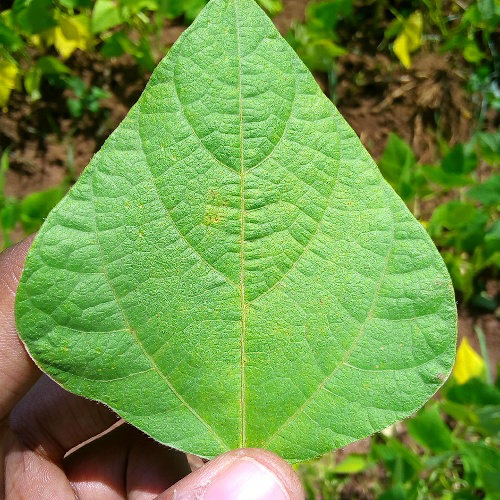

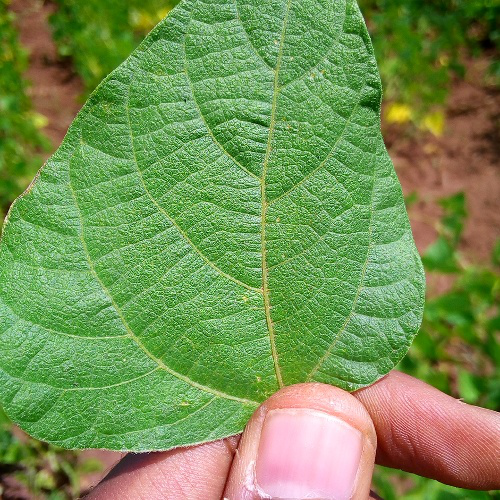

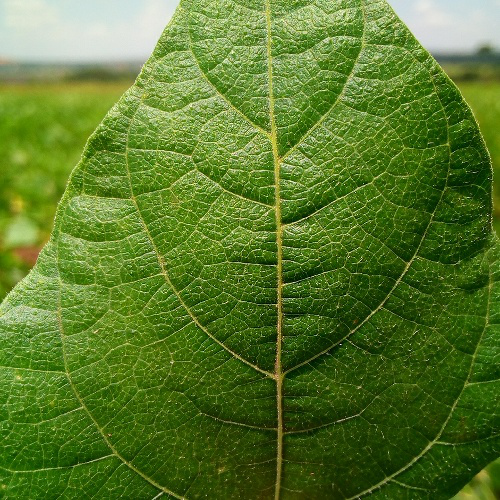

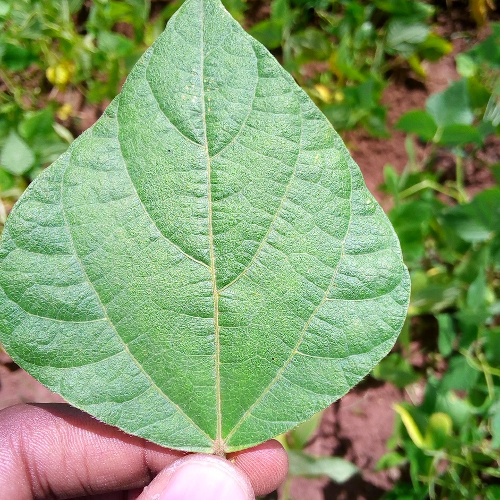

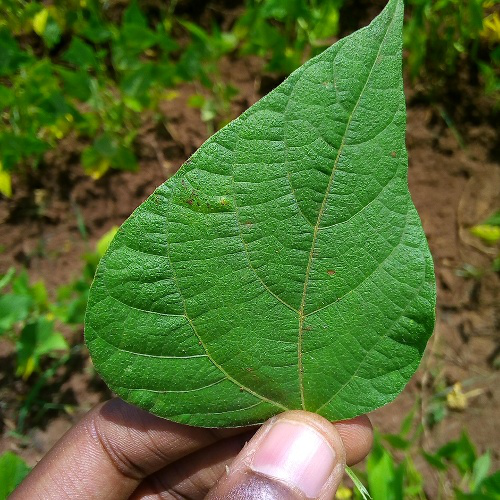

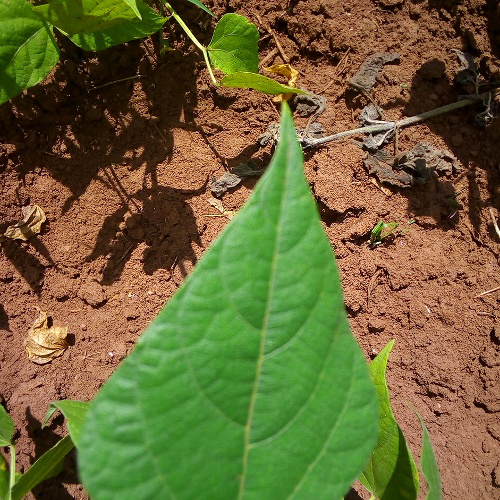

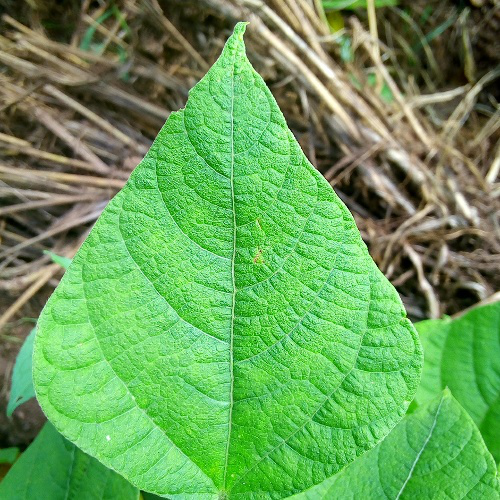

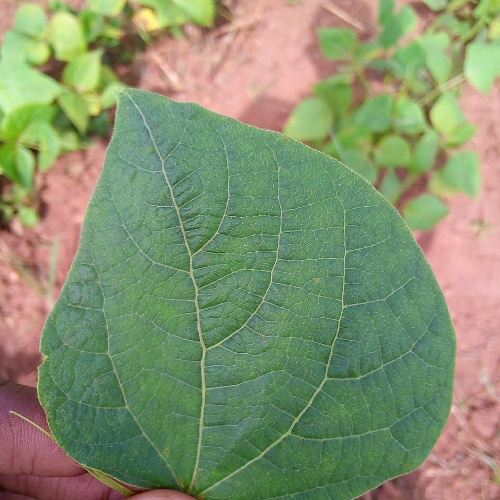

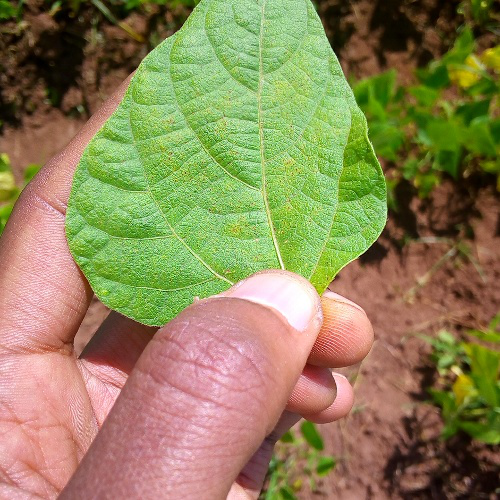

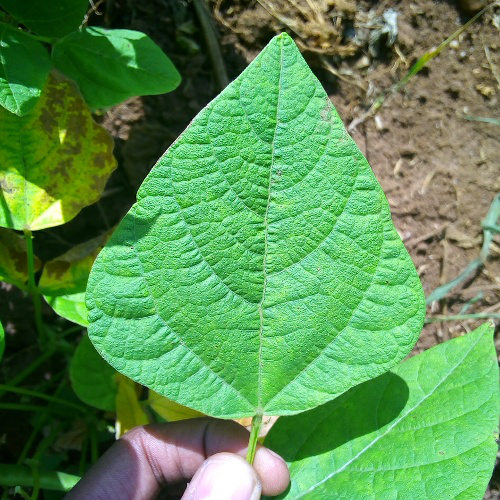

In [ ]:
# view the images from dataset
for i in range(10):
  display(dataset['train'][i]['image'])

In [ ]:
# View the dataset labels
dataset['train'].features['labels']

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

* What information do we have for each sample? 

  [Based on dataset.info.features]
  1.   image_file_path
  2.   image
  3.   labels

* How many training samples do we have? Validation samples? Test samples? 

  1.  Training Samples: 1034
  2.  Validation Samples: 133
  3.  Test SamplesL 128

* How many different classes are there in this dataset, and what are the class labels? 

  1.  3 Classes
  2.  Class Labels: angular_leaf_spot, bean_rust, healthy

* Looking at the first 10 training images, do you notice anything interesting about the images in the dataset? Are they as diverse/representative as you would expect or do they have limitations? 

1. Many healthy leaves

# Step 2: Loading a Pretrained Model

We will be using the `transformers` library, which can load tens of thousands of machine learning models with a few lines of code. It can also be used to fine-tune these models. Learn more about the `transformers` library here: https://huggingface.co/docs/transformers/index

Specifically, we will be using the `Vision Image Transformer` model that is available to anyone from the Hugging Face Hub: https://huggingface.co/google/vit-base-patch16-224. While the details of vision transformers are beyond the scope of this course, we will point out that they are a successor of the widely used convolutional neural network (CNN) architecture and tend to perform better than CNNs at the same tasks (image classificaiton, segmentation, etc.)

Let's start by seeing how the Vision Image Transformer model performs without any further fine-tuning.

* **Load the Vision Image Transformer Model for Inference**

In [ ]:
import transformers
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the model as inference
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.eval()
model.to(device);

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

We also need to load the **feature extractor** corresponding to the model, so that we can convert the input images into feature vectors that the model can take as input.

In [ ]:
# preparing the dataset  [NLP: Tokenizers, Vision: Feature Extractors]
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

* **Use the Vision Image Transformer Model to Make a Prediction on the Training Images**

The documentation here may be helpful: https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification.forward.example

In [ ]:
# First we get the features corresponding to the first training image
encoding = feature_extractor(images=dataset['train'][0]['image'], return_tensors="pt")

# Then pass it through the model and get a prediction
with torch.no_grad():
  logits = model(**encoding).logits   # shape of classification

prediction = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[prediction])

RuntimeError: ignored

* Try running the model on the first 10 samples in the dataset. 

In [ ]:
def display_predictions(total):
  for count in range(total):
      inputs = feature_extractor(images=dataset['train'][count]['image'], return_tensors="pt")
      with torch.no_grad():
        logits = model(**inputs).logits

      prediction_label = logits.argmax(-1).item()
      print(f"Predicted class: {count}", model.config.id2label[prediction_label])

display_predictions(10)

What is the most common prediction? Why do you think that is? 
1. leaf beetle, chrysomelid

# Step 3: Fine-tuning Your Model on the Dataset

Off the shelf, the Vision Image Transformer will not be usable for the task that we have in mind, since it was trained for "general" image classification, not for the specific categories that we would like to predict. As a result, we will need to "fine-tune" our model.

Learn more about fine-tuning models with the `transformers` library here: https://huggingface.co/docs/transformers/training

We will also need to decide which metric to use for our task. Since our task is a simple image classification task, the `accuracy` metric seems reasonable: https://huggingface.co/spaces/evaluate-metric/accuracy



* **Preprocess the Dataset**

To make things faster, we are going to preprocess the entire dataset so that we convert all of the images to feature vectors. This will allow us to speed up the training as we can pass the feature vectors directly. This code has already been written for you:


In [ ]:
import torch

def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

* **Load the Accuracy Metric**

We now have to decide on a *metric* we will use to measure the performance for our machine learning model. A natural choice for image classification is *accuracy*, which measures the percentage of images that are predicted to have the correct label. 

Read about the `evaluate` library, which contains many common machine learning metrics here: https://github.com/huggingface/evaluate

And use the `evaluate.load()` to load the accuracy metric:

In [ ]:
from transformers import AutoModelForImageClassification
import numpy as np
import evaluate

labels = dataset['train'].features['labels'].names

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True 
)
metric = evaluate.load('accuracy')
def compute_metrics(sample):
    return metric.compute(
        predictions=np.argmax(sample.predictions, axis=1), 
        references=sample.label_ids)

* **Fine-Tune the Vision Image Transformer Model on the Entire Training Set**

Now, we will take all of the code that you have written and use it to fine-tune the ViT model on the beans dataset. Simply run the code below, and your model will fine-tune for 4 epochs. On a **GPU**, this should take less than 5 minutes.

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-week-01",  # output directory where the model predictions and checkpoints will be written
  per_device_train_batch_size=16 , # batch size
  learning_rate=2e-4,             # learning rate
  num_train_epochs=4,             # number of epochs to train for
  remove_unused_columns=False,    # keep the "image" column
  logging_steps=10,               # how often to print training metrics
  eval_steps=100,                 # how often to measure on the evaluation set
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model("saved_model_files")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Step 4: Reporting Model Metrics

* **Measure Loss on the Validation Dataset**

In [ ]:
from transformers import pipeline
from evaluate import evaluator

metric = evaluate.load("accuracy")
task_evaluator = evaluator("image-classification")
data = load_dataset('beans', split='validation')

In [ ]:
pipe = pipeline(task="image-classification", model=model,feature_extractor=feature_extractor, device=0)
results = task_evaluator.compute(model_or_pipeline=pipe, feature_extractor=feature_extractor, data=data, label_column="labels", metric=metric, label_mapping=pipe.model.config.label2id)
print(results)